In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pickle
import matplotlib.pyplot as plt
import os
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import torch.nn.functional as F
from early_stopping_pytorch import EarlyStopping

In [2]:
class SequenceLabelingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.02):
        super(SequenceLabelingRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True,bias=True) #Bidirectional LSTM
        self.fc = nn.Linear(hidden_size*2, output_size) #*2 because bidirectional

    def forward(self, x):
        out, _ = self.rnn(x) 
        out = self.fc(out) 
        return out

In [3]:
# Load data
with open('/scratch/da3245/datasets/timeseries_voltage/stratified_no_overlap.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [4]:
# Convert back to tensors for DataLoader
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Add channel dimension
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)  
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_val_loss = float('inf')
input_size = 1
hidden_size = 64
num_layers = 3
output_size = 2 #Binary classification for each timestep
dropout_rate = 0.02
lr=0.0005

In [6]:
model = SequenceLabelingRNN(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=20, verbose=True) #https://github.com/Bjarten/early-stopping-pytorch

/ext3/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Training loop
num_epochs = 50
val_interval = 1
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, output_size), labels.view(-1)) #Reshape for loss calculation
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
        val_losses.append(val_loss)
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
            print("Saving best model...")
        else:
            early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

Epoch [1/50], Loss: 0.0552
Epoch [1/50], Train Loss: 0.0040, Val Loss: 0.0076
Saving best model...
Epoch [2/50], Loss: 0.0203
Epoch [2/50], Train Loss: 0.0038, Val Loss: 0.0075
Saving best model...
Epoch [3/50], Loss: 0.0000
Epoch [3/50], Train Loss: 0.0024, Val Loss: 0.0061
Saving best model...
Epoch [4/50], Loss: 0.0012
Epoch [4/50], Train Loss: 0.0021, Val Loss: 0.0059
Saving best model...
Epoch [5/50], Loss: 0.0000
Epoch [5/50], Train Loss: 0.0024, Val Loss: 0.0058
Saving best model...
Epoch [6/50], Loss: 0.0001
Epoch [6/50], Train Loss: 0.0020, Val Loss: 0.0056
Saving best model...
Epoch [7/50], Loss: 0.0000
Epoch [7/50], Train Loss: 0.0011, Val Loss: 0.0052
Saving best model...
Epoch [8/50], Loss: 0.0000
Epoch [8/50], Train Loss: 0.0011, Val Loss: 0.0049
Saving best model...
Epoch [9/50], Loss: 0.0050
Epoch [9/50], Train Loss: 0.0010, Val Loss: 0.0051
Validation loss decreased (inf --> 0.005056).  Saving model ...
Epoch [10/50], Loss: 0.0000
Epoch [10/50], Train Loss: 0.0009, Val

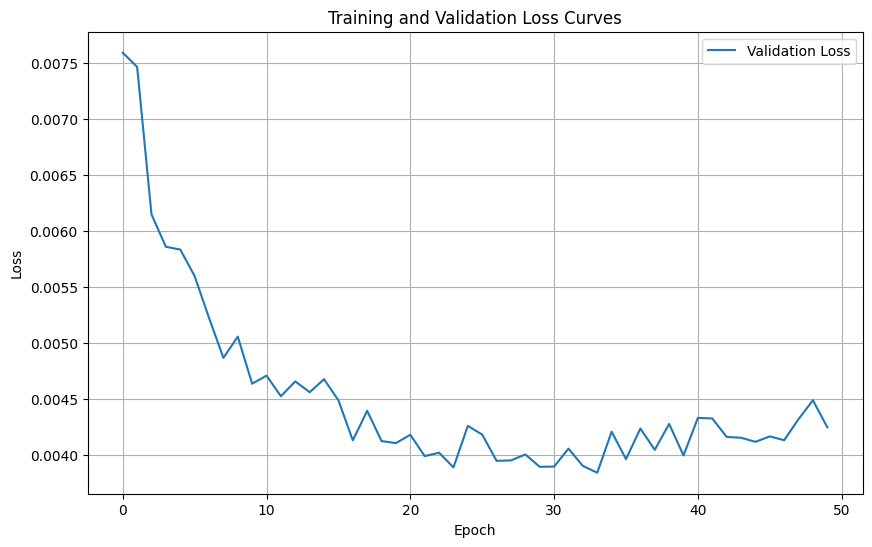

In [8]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
#plt.plot([loss/len(train_loader) for loss in train_losses], label='Training Loss')
#plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

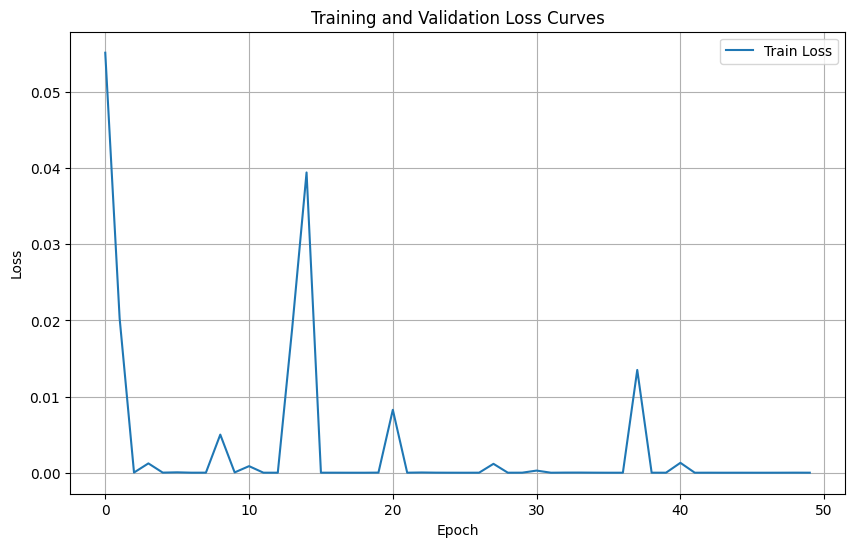

In [9]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
#plt.plot([loss/len(train_loader) for loss in train_losses], label='Training Loss')
#plt.plot(train_losses, label='Training Loss')
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, device, num_epochs=50, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        num_train_batches = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            num_train_batches += 1

        train_losses.append(epoch_train_loss / num_train_batches)

        model.eval()
        epoch_val_loss = 0.0
        num_val_batches = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).permute(0, 2, 1)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                epoch_val_loss += loss.item()
                num_val_batches += 1

        val_losses.append(epoch_val_loss / num_val_batches)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    precision, recall, f1, auc = evaluate_model(model, test_loader, device)
    return f1


train_sizes = np.linspace(0.1, 1.0, 10)  # 10 steps from 10% to 100% of training data
f1_scores = []
for train_size in train_sizes:
    num_train_samples = int(len(X_train) * train_size)
    train_subset_indices = np.random.choice(len(X_train), num_train_samples, replace=False)
    X_train_subset = X_train[train_subset_indices]
    y_train_subset = y_train[train_subset_indices]

    train_subset_dataset = TensorDataset(X_train_subset, y_train_subset)
    train_subset_loader = DataLoader(train_subset_dataset, batch_size=32, shuffle=True)

    #Train and evaluate the model
    model = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout).to(device)
    f1 = train_and_evaluate(model, train_subset_loader, val_loader, test_loader, device)
    f1_scores.append(f1)

NameError: name 'TemporalConvNet' is not defined

In [ ]:
#model = SequenceLabelingRNN(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
model = AttentionLSTM(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels[:,0])
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1
#num_channels = [32, 64, 128]
num_channels = [32, 64, 128, 256]
kernel_size = 3
dropout = 0.002

model = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
early_stopping = EarlyStopping(patience=10, verbose=True) #https://github.com/Bjarten/early-stopping-pytorch

#from torchinfo import summary
#print(summary(model, input_size=(32,1,200))) 

In [43]:
# Training loop
num_epochs = 50
val_interval = 1
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device).permute(0,2,1)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1,2), labels.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).permute(0,2,1)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
            print("Saving best model...")
        else:
            early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

Epoch [1/50], Loss: 0.0327
Epoch [1/50], Train Loss: 0.0109, Val Loss: 0.0136
Validation loss decreased (inf --> 0.013646).  Saving model ...
Epoch [2/50], Loss: 0.0044
Epoch [2/50], Train Loss: 0.0122, Val Loss: 0.0133
Validation loss decreased (0.013646 --> 0.013296).  Saving model ...
Epoch [3/50], Loss: 0.0037
Epoch [3/50], Train Loss: 0.0105, Val Loss: 0.0130
Validation loss decreased (0.013296 --> 0.012979).  Saving model ...
Epoch [4/50], Loss: 0.0260
Epoch [4/50], Train Loss: 0.0102, Val Loss: 0.0128
Validation loss decreased (0.012979 --> 0.012758).  Saving model ...
Epoch [5/50], Loss: 0.0035
Epoch [5/50], Train Loss: 0.0126, Val Loss: 0.0126
Validation loss decreased (0.012758 --> 0.012550).  Saving model ...
Epoch [6/50], Loss: 0.0076
Epoch [6/50], Train Loss: 0.0126, Val Loss: 0.0128
EarlyStopping counter: 1 out of 10
Epoch [7/50], Loss: 0.0020
Epoch [7/50], Train Loss: 0.0097, Val Loss: 0.0123
Validation loss decreased (0.012550 --> 0.012301).  Saving model ...
Epoch [8/5

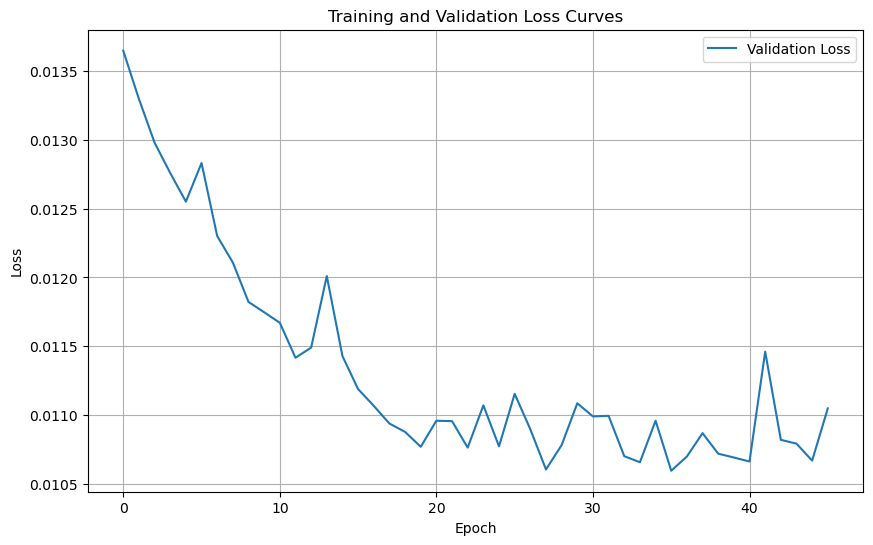

In [44]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
#plt.plot([loss/len(train_loader) for loss in train_losses], label='Training Loss')
#plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from torchviz import make_dot
import torchviz
# Dummy input for visualization
dummy_input = torch.randn(1, 200, 1).to(device)  # [batch_size, seq_len, input_channels]
dummy_input = dummy_input.permute(0, 2, 1)  # Match input format for Conv1d (B, C, L)

# Forward pass
output = model(dummy_input)

# Generate and save visualization
#graph = make_dot(output, params=dict(model.named_parameters()))
dot = torchviz.make_dot(
        output, 
        params=dict(model.named_parameters()),
        show_attrs=False,  # Hide node attributes
        show_saved=False   # Hide saved tensors
    )
simplify=True
if simplify:
        dot.graph_attr.update({
            'rankdir': 'TB',    # Top to Bottom layout
            'size': '8,5',      # Reduce overall graph size
            'dpi': '300',       # Increase resolution
        })
        
        # Reduce node complexity
        dot.node_attr.update({
            'shape': 'box',     # Simpler node shape
            'style': 'filled',  # Fill color
            'fillcolor': 'lightblue',  # Light background
            'fontsize': '10',   # Smaller font
        })
        
        # Reduce edge complexity
        dot.edge_attr.update({
            'color': 'gray',    # Muted edge color
            'penwidth': '0.5',  # Thinner edges
        })
dot.render("TemporalConvNet", format="png")  # Save as PNG


'TemporalConvNet.png'

In [11]:
from sklearn.metrics import precision_recall_curve

def evaluate_model(model, data_loader, device):
    """Evaluates the model and computes various metrics."""
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    all_probabilities = []
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #outputs = model(inputs.permute(0,2,1))
            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            test_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=2) #Softmax to get probabilities
            threshold = 0.5325 # Example: Lower threshold
            predicted = (probabilities[:, :, 1] > threshold).long()
            #_, predicted = torch.max(outputs.data, 2)

            all_true_labels.extend(labels.view(-1).cpu().numpy())
            all_predicted_labels.extend(predicted.view(-1).cpu().numpy())
            all_probabilities.extend(probabilities.view(-1,2).cpu().numpy())
            total += labels.view(-1).size(0)
            correct += (predicted.view(-1) == labels.view(-1)).sum().item()
    
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Calculate metrics
    accuracy=100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(all_true_labels, np.array(all_probabilities)[:, 1]) #Calculate AUC
    except ValueError:
        auc = np.nan
        print("Only one class present in y_true. ROC AUC score is not defined in that case.")

    probabilities_positive_class = np.array(all_probabilities)[:, 1]  # Probability of the positive class
    precision_curve, recall_curve, thresholds = precision_recall_curve(all_true_labels, probabilities_positive_class)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)  # F1 for each threshold
    best_threshold = thresholds[np.argmax(f1_scores)]  # Optimal threshold
    best_f1_score = np.max(f1_scores)

    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"Best F1-Score at Optimal Threshold: {best_f1_score:.4f}")
    
    return precision, recall, f1, auc, accuracy,best_f1_score,best_threshold,test_loss

# Example usage: Evaluate the model on the test set
precision, recall, f1, auc, accuracy,best_f1,best_thresh,test_loss= evaluate_model(model, test_loader, device)
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Test Loss: 0.0041
Optimal Threshold: 0.5889
Best F1-Score at Optimal Threshold: 0.9036
Accuracy of the model on the test set: 99.84%
Precision: 0.8925
Recall: 0.9133
F1-score: 0.9028
AUC: 0.9997


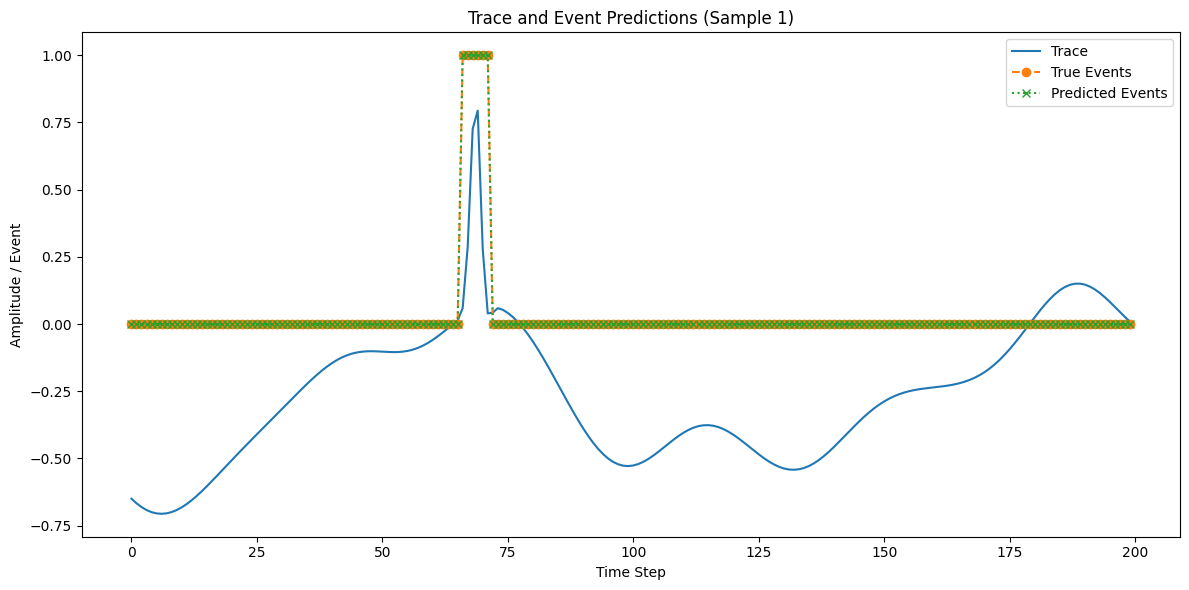

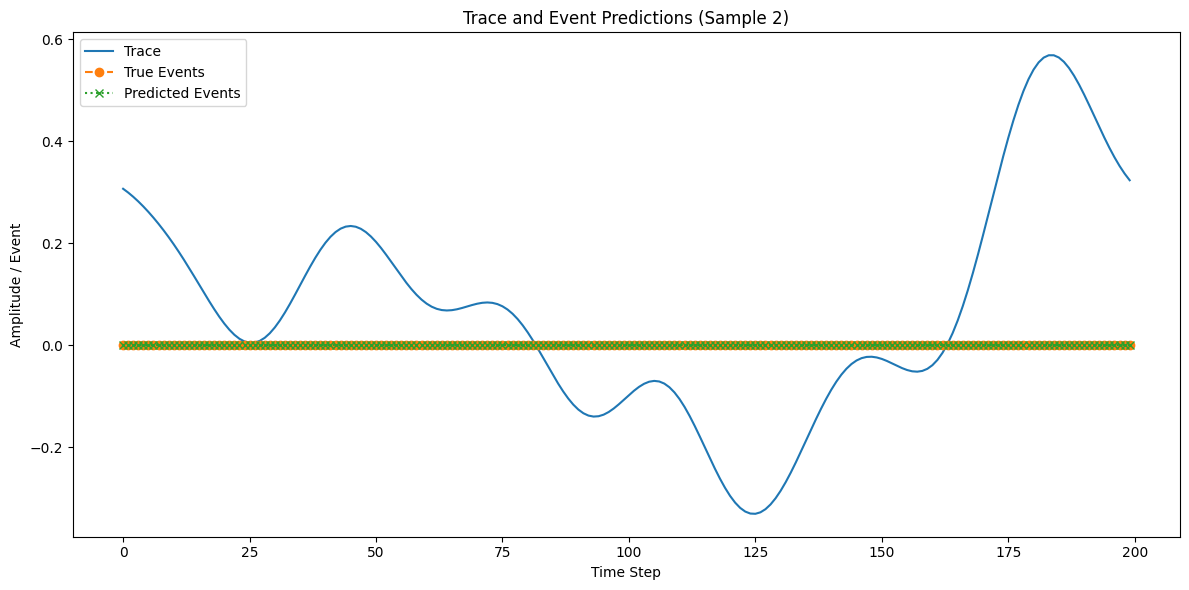

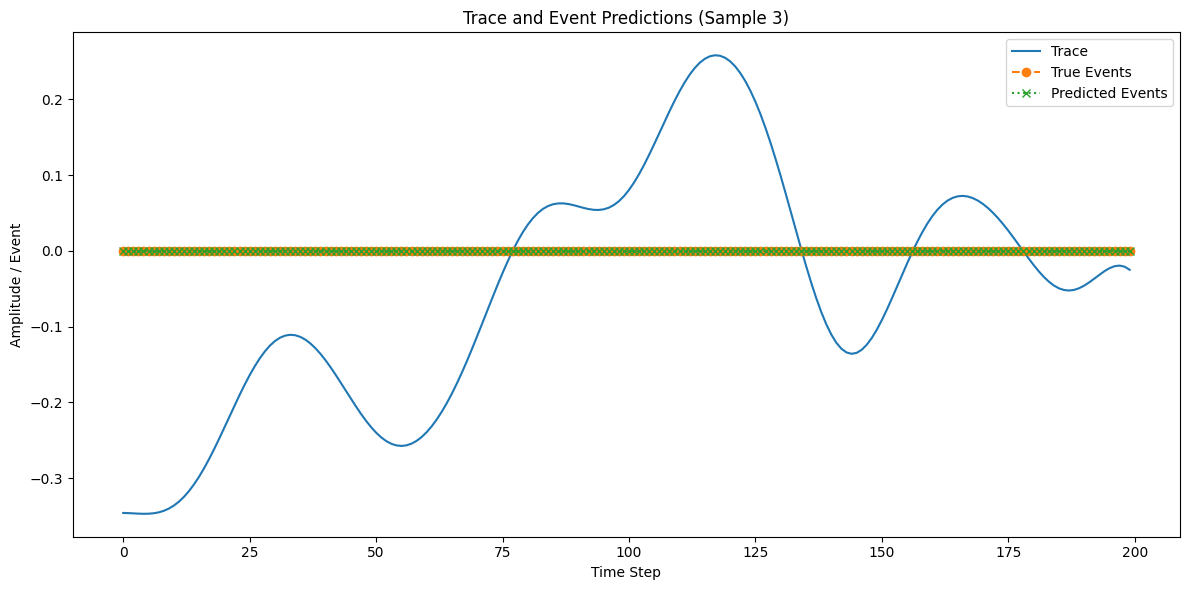

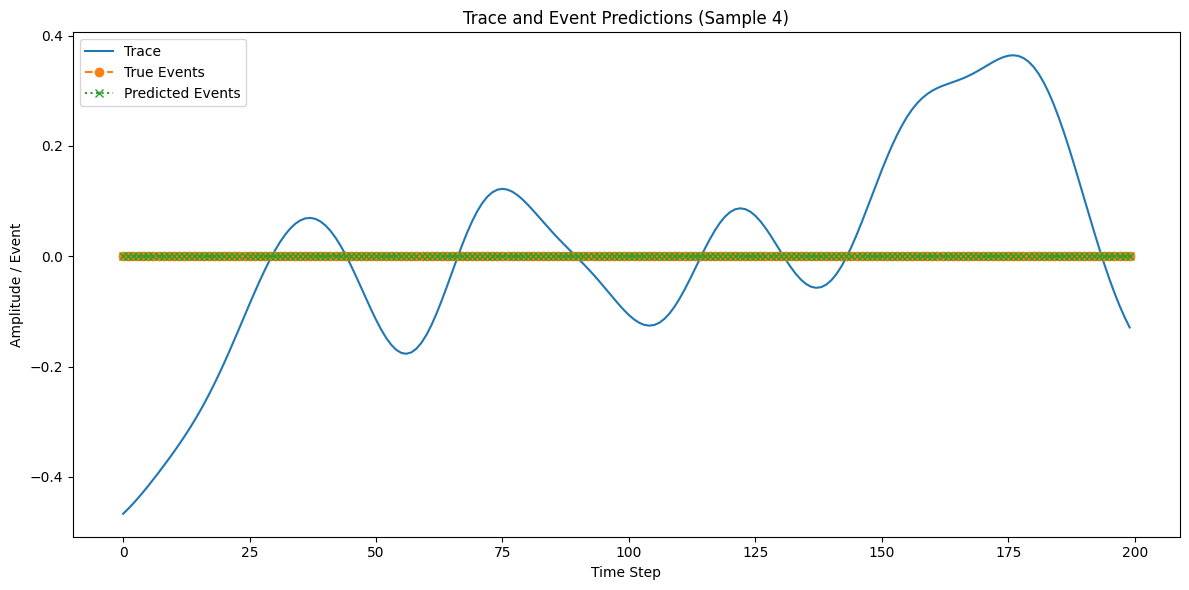

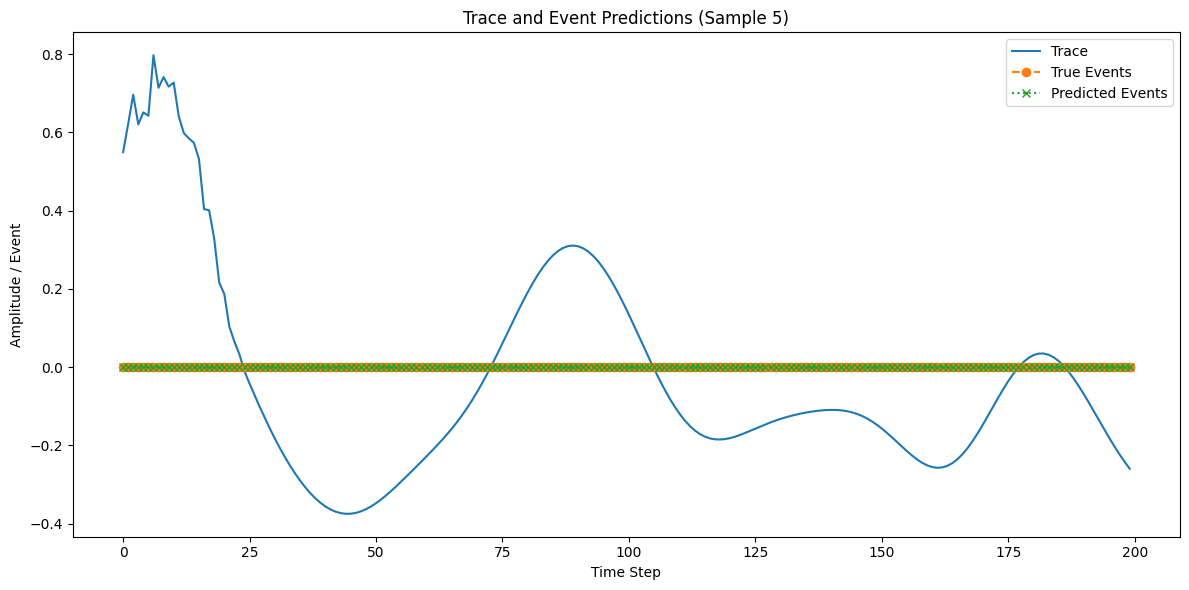

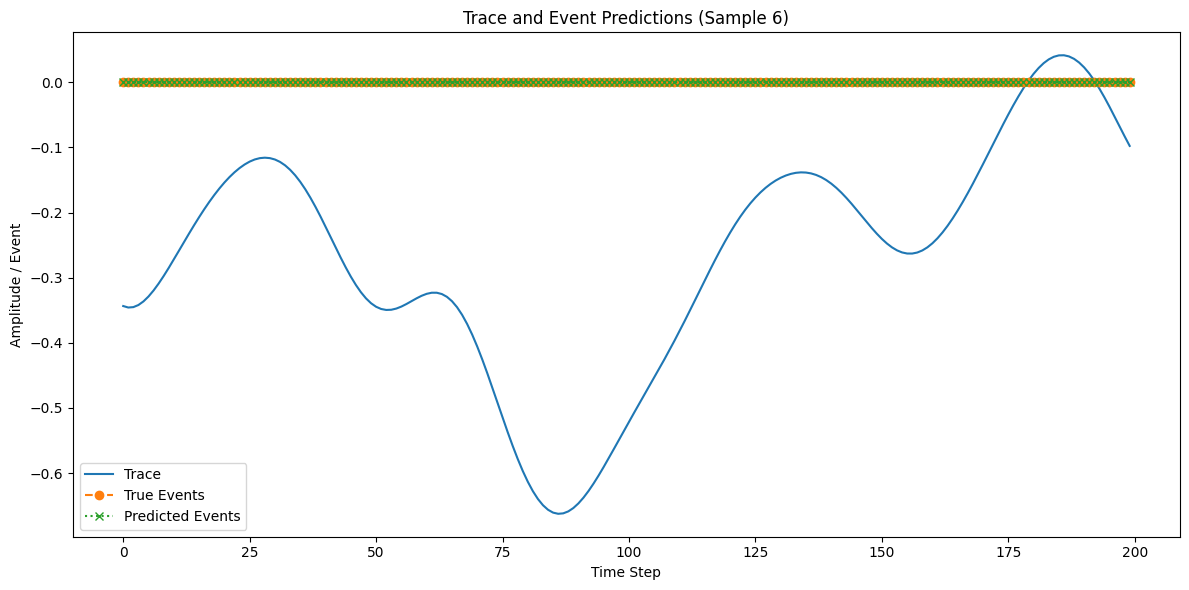

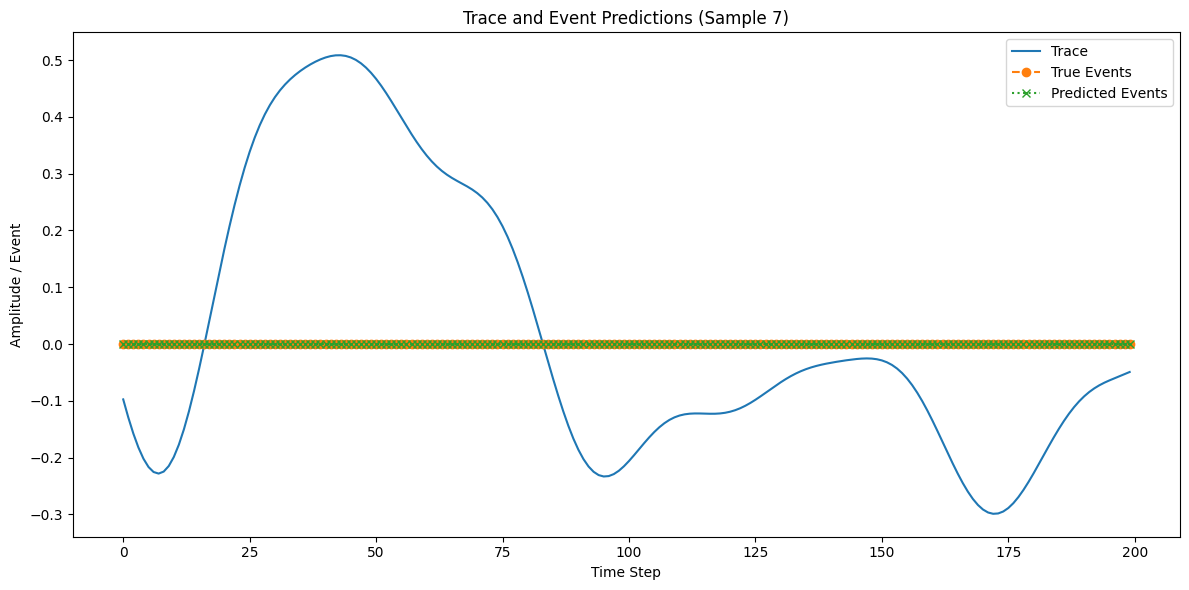

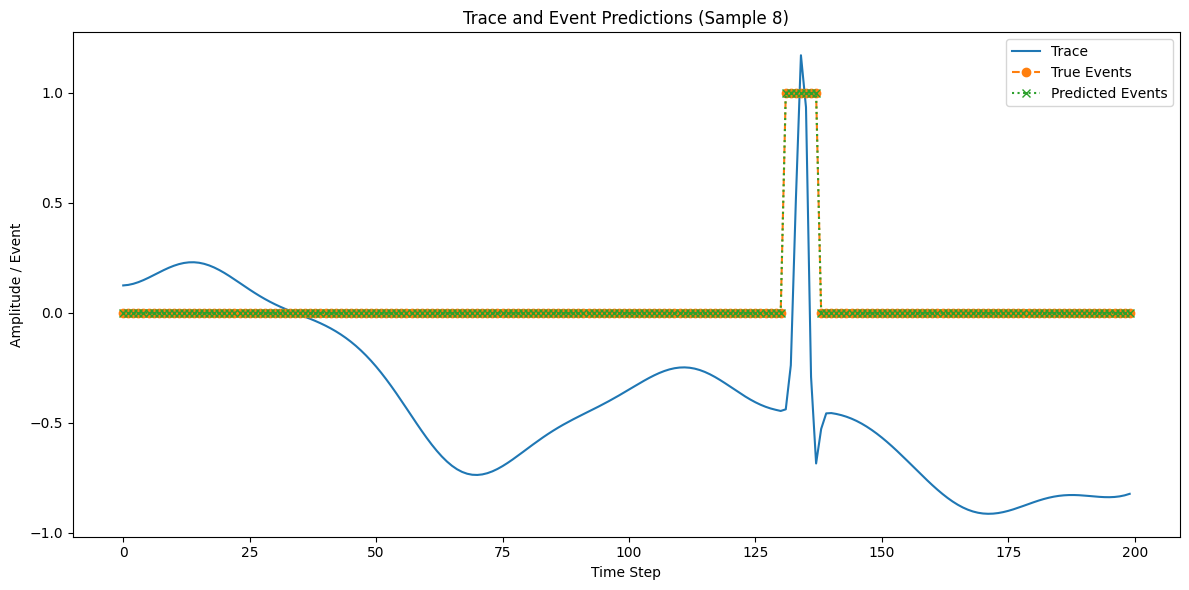

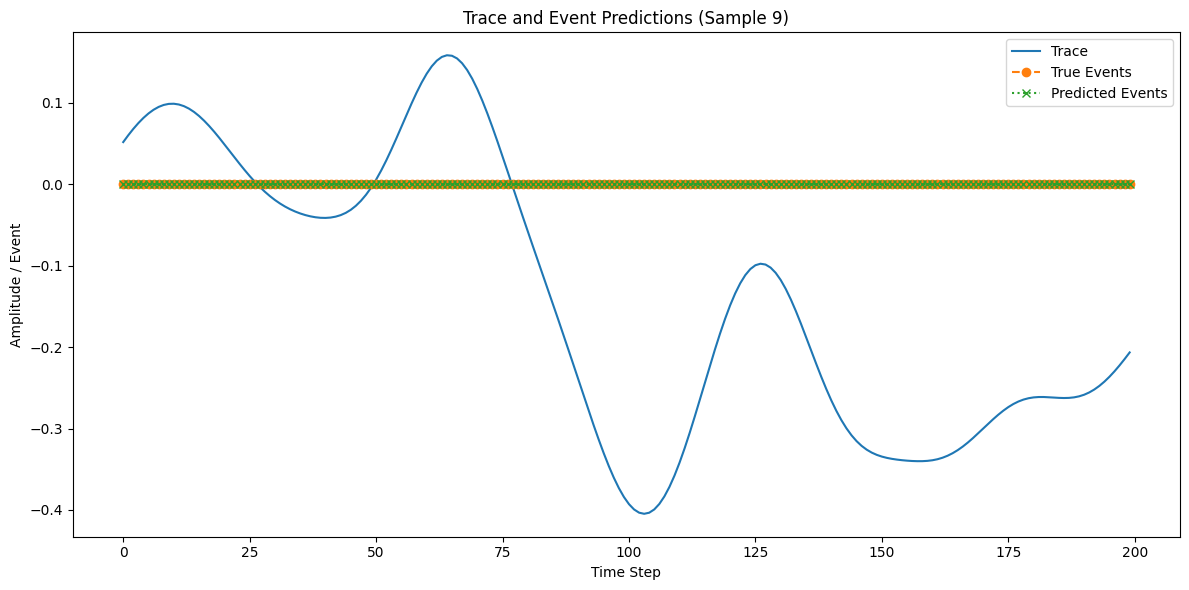

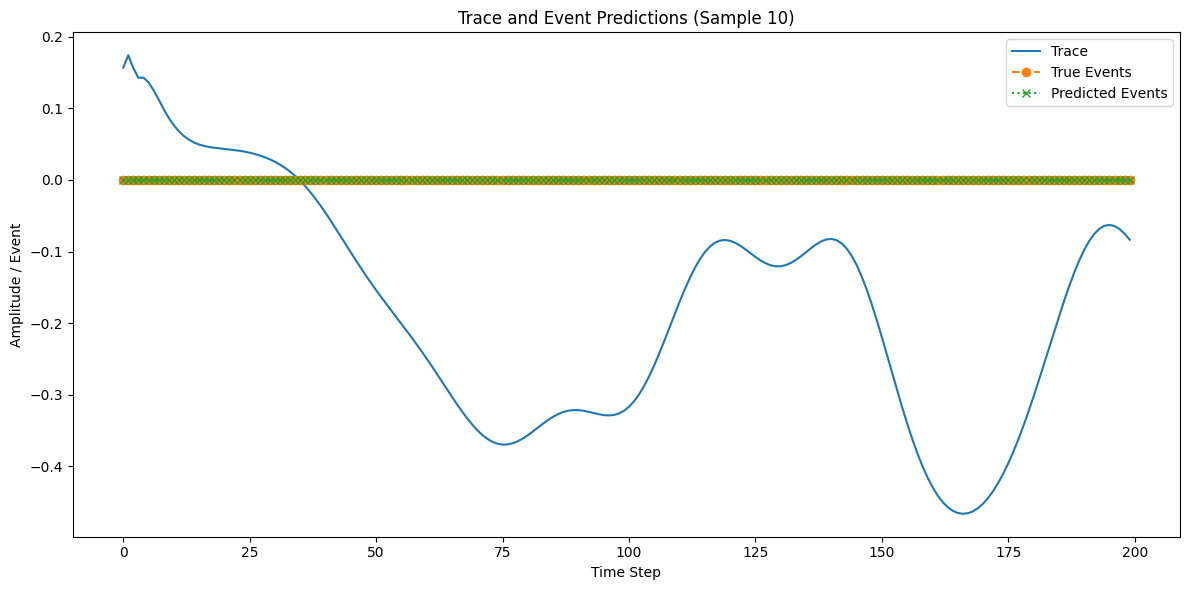

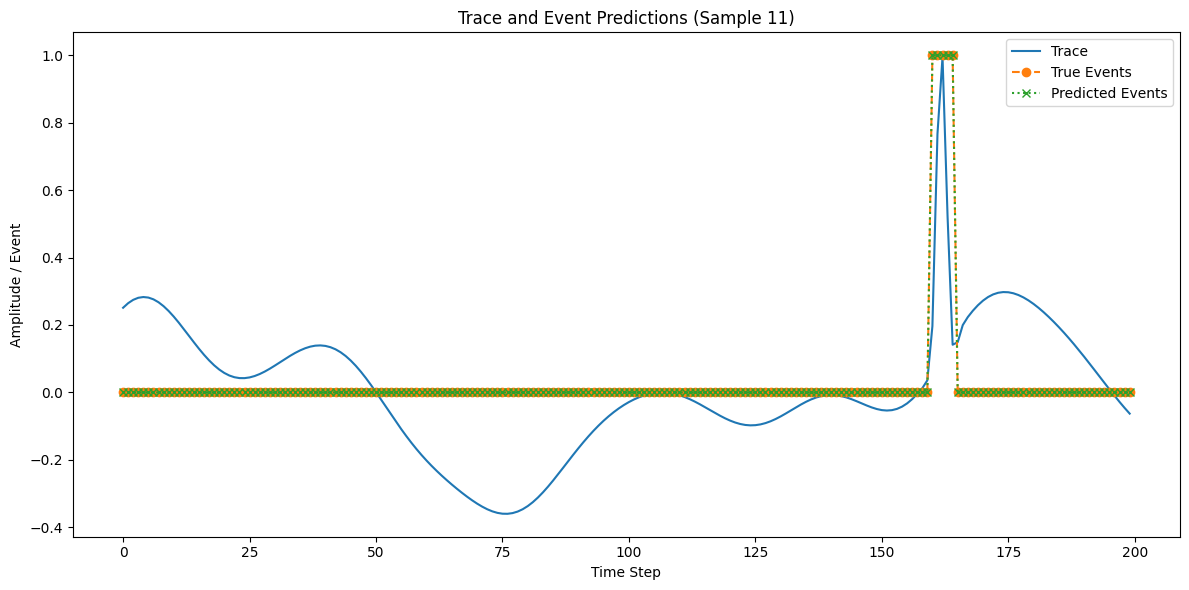

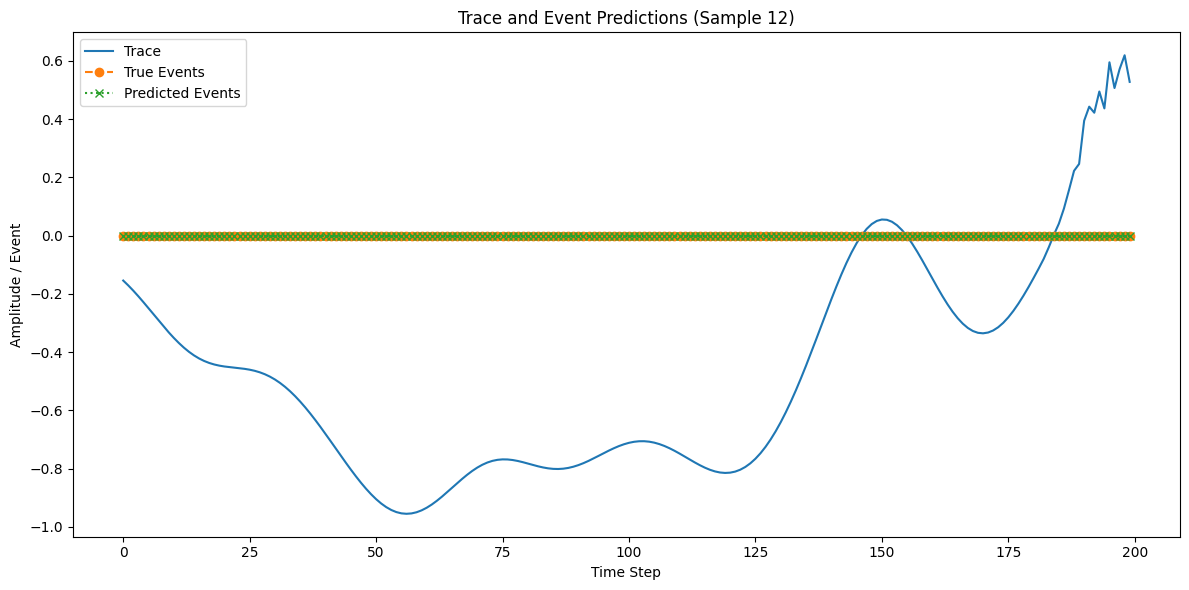

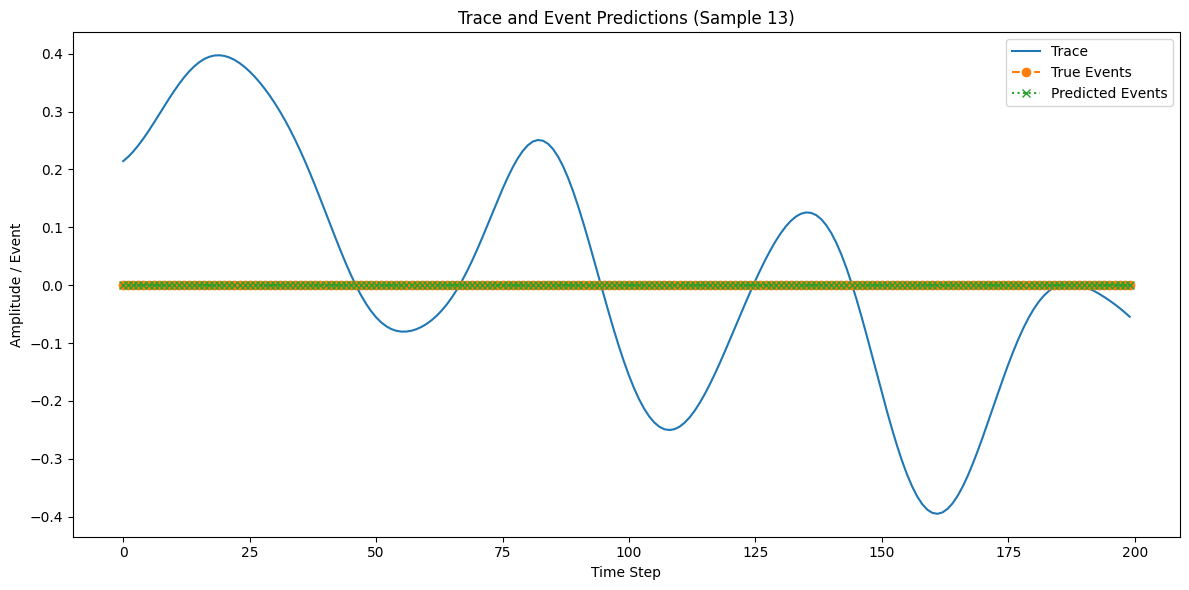

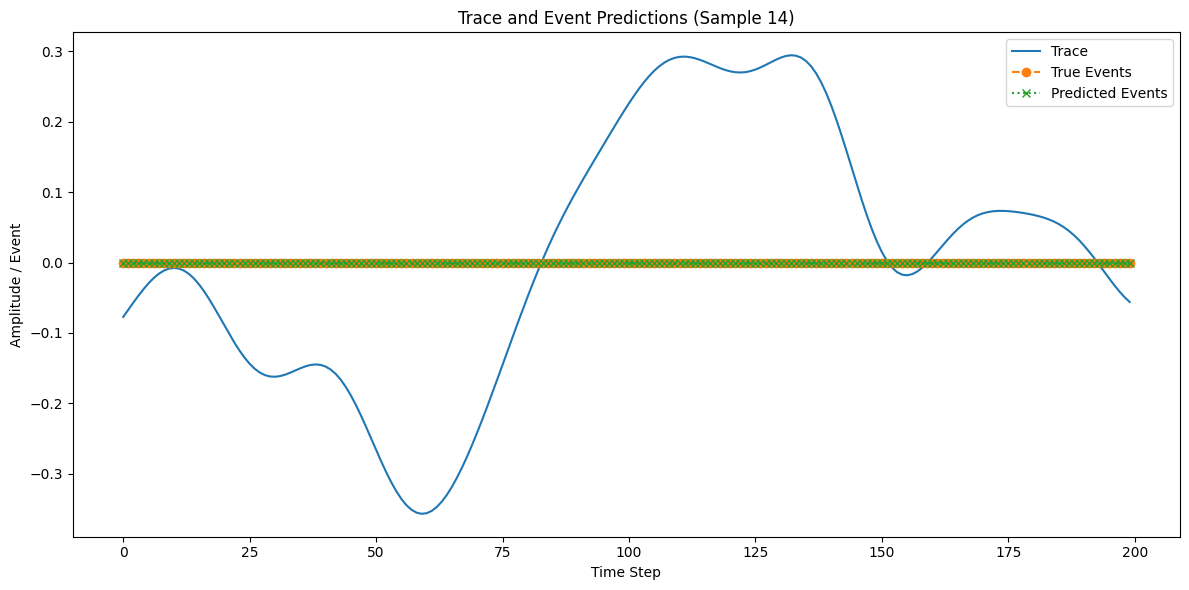

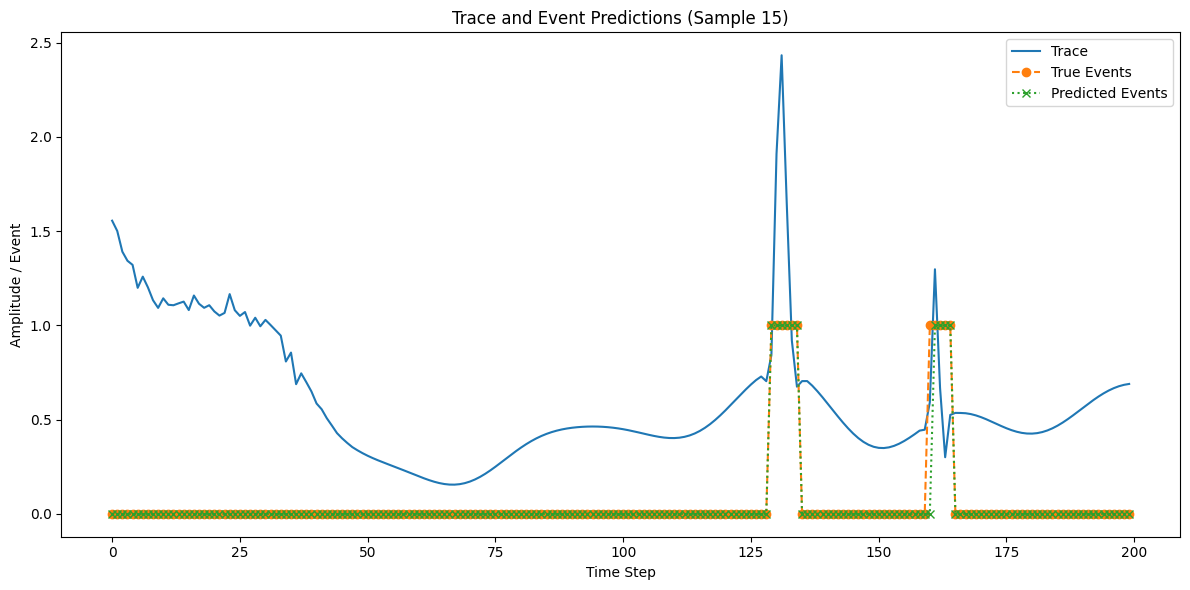

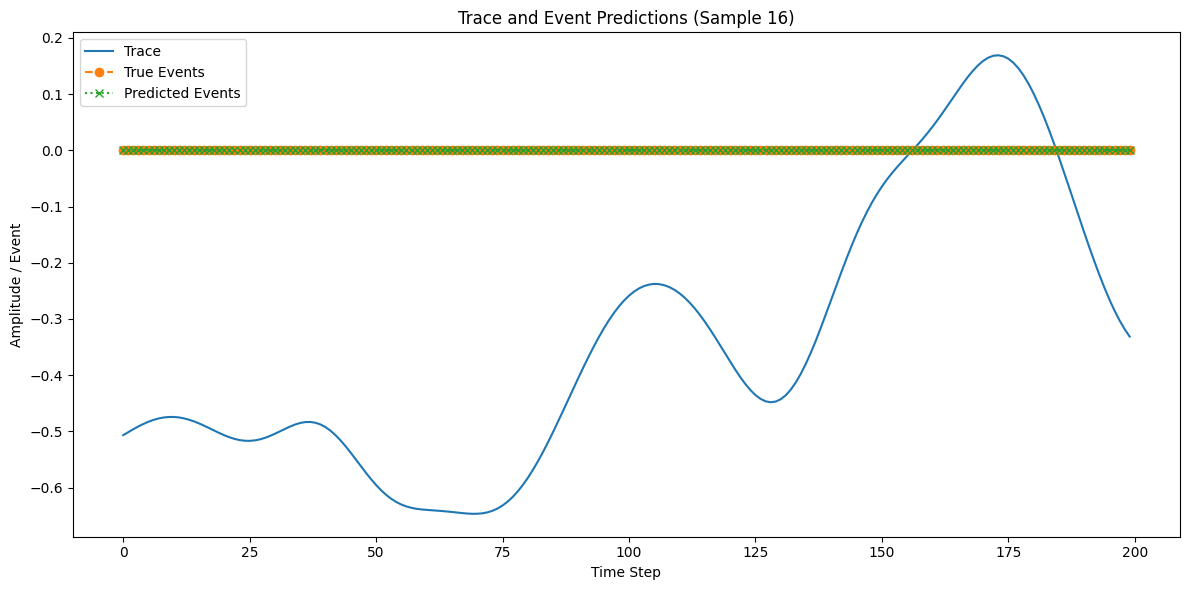

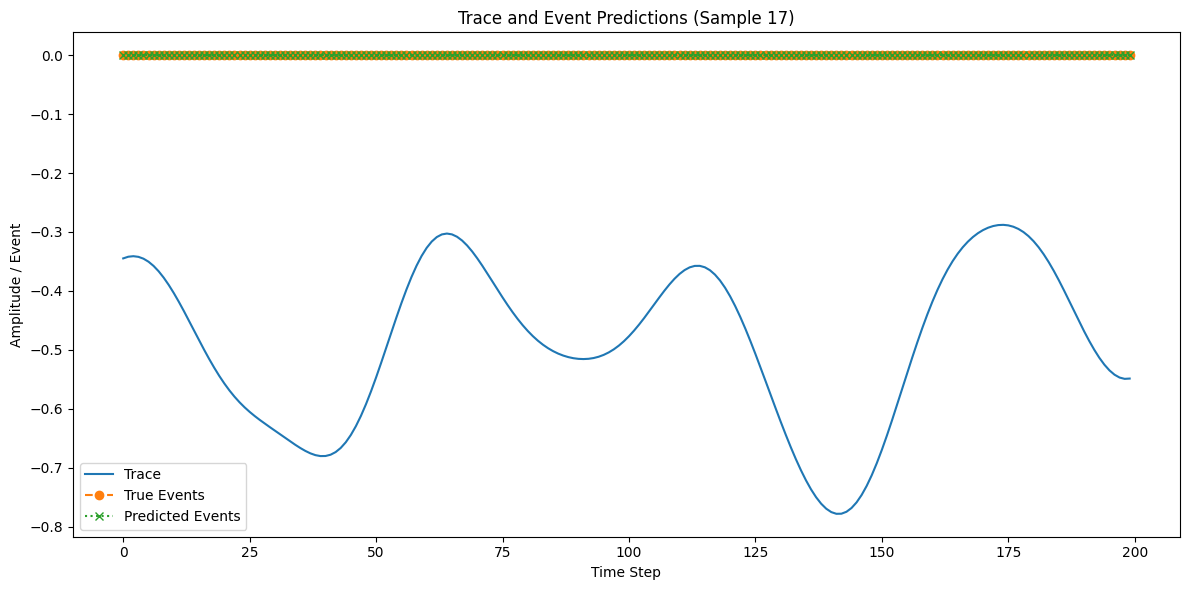

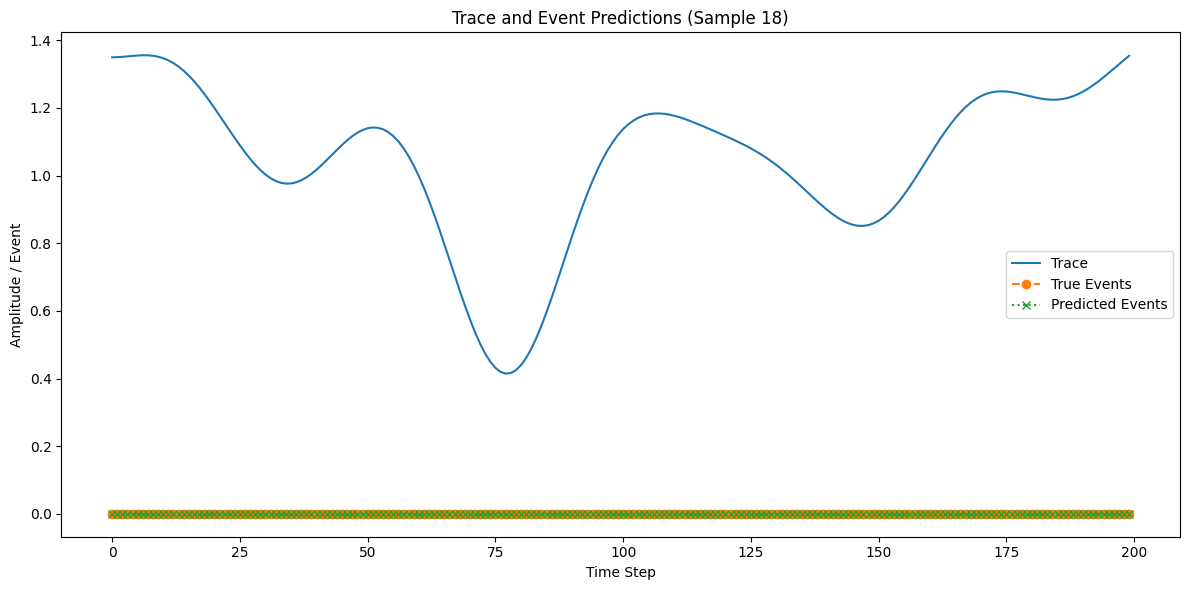

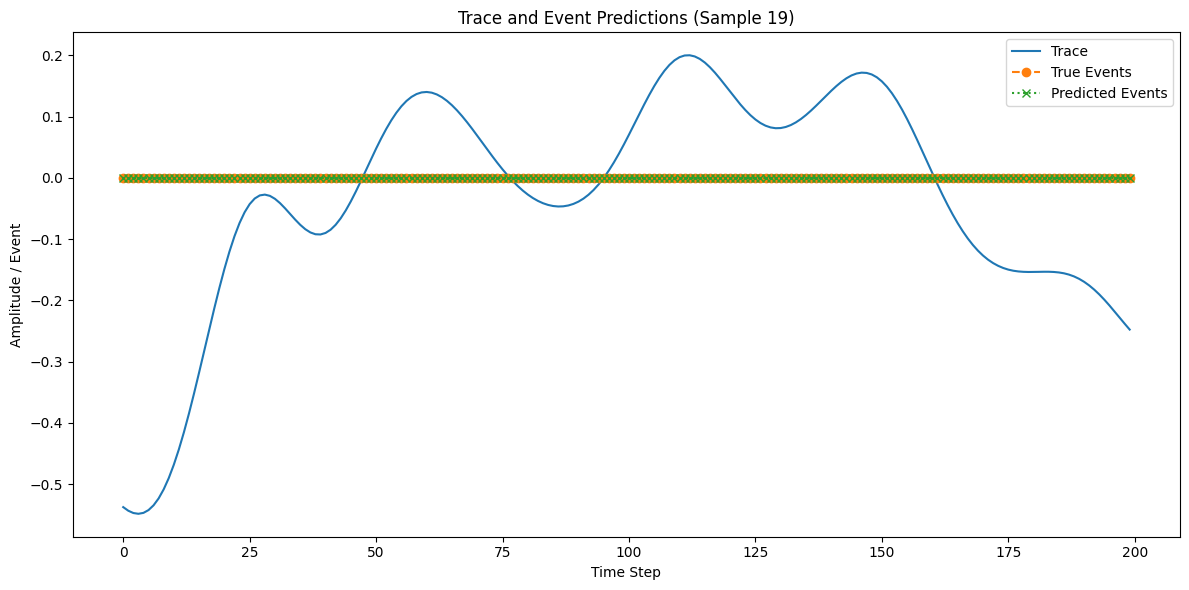

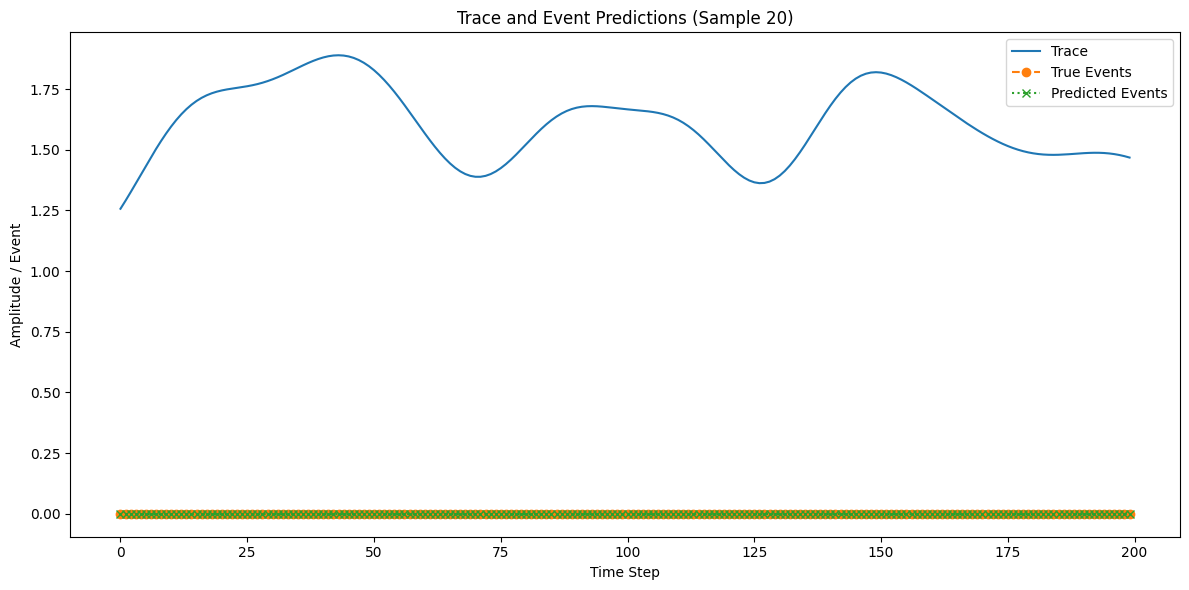

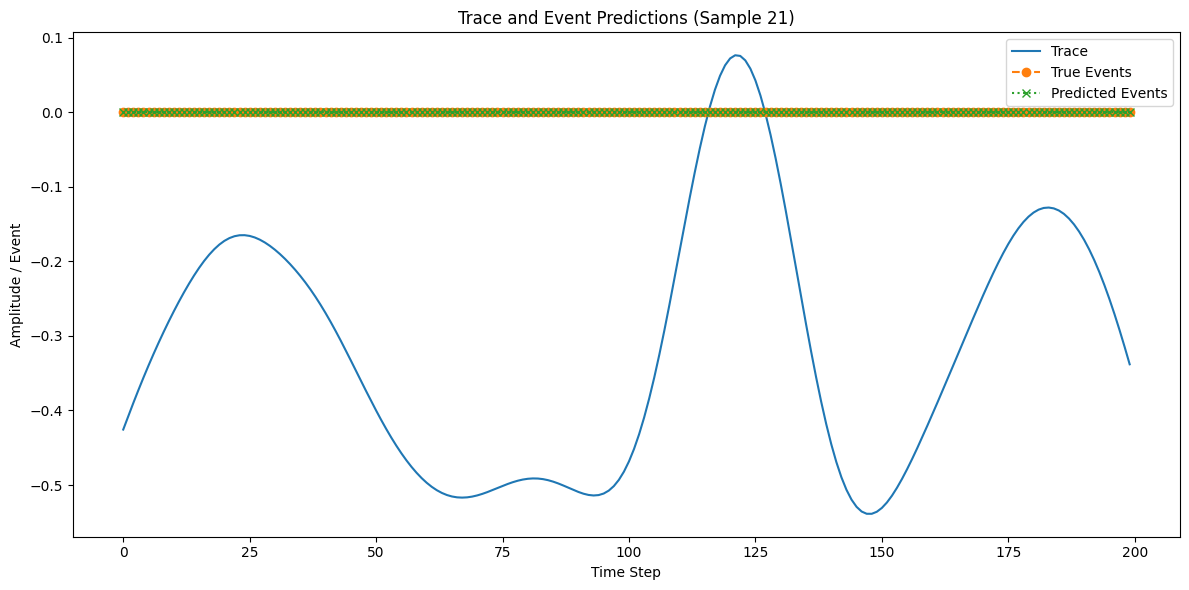

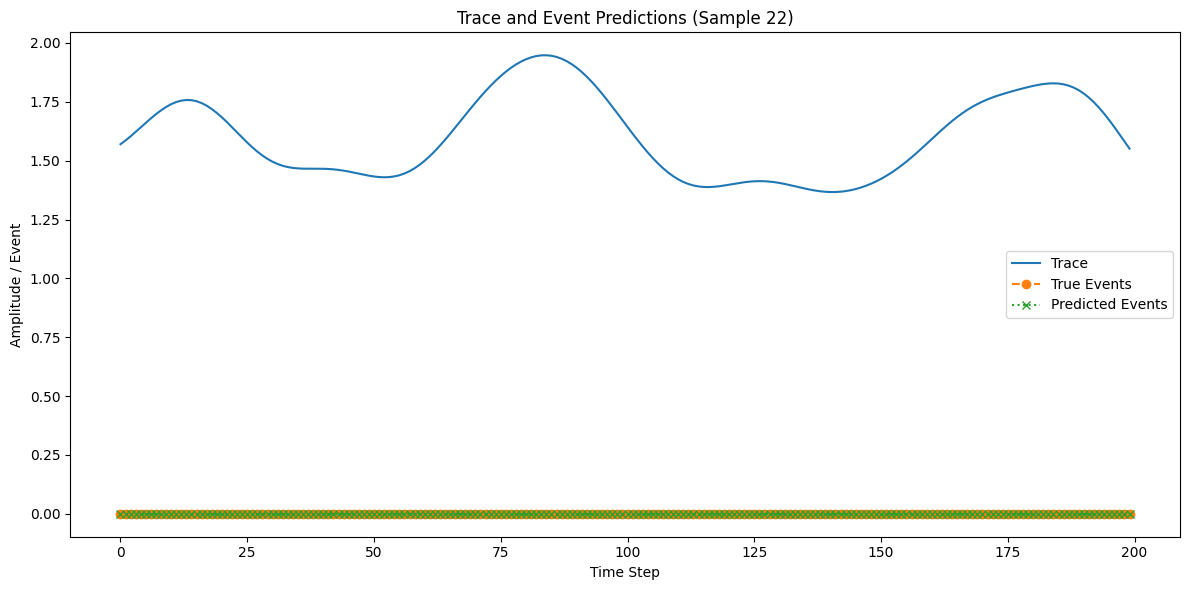

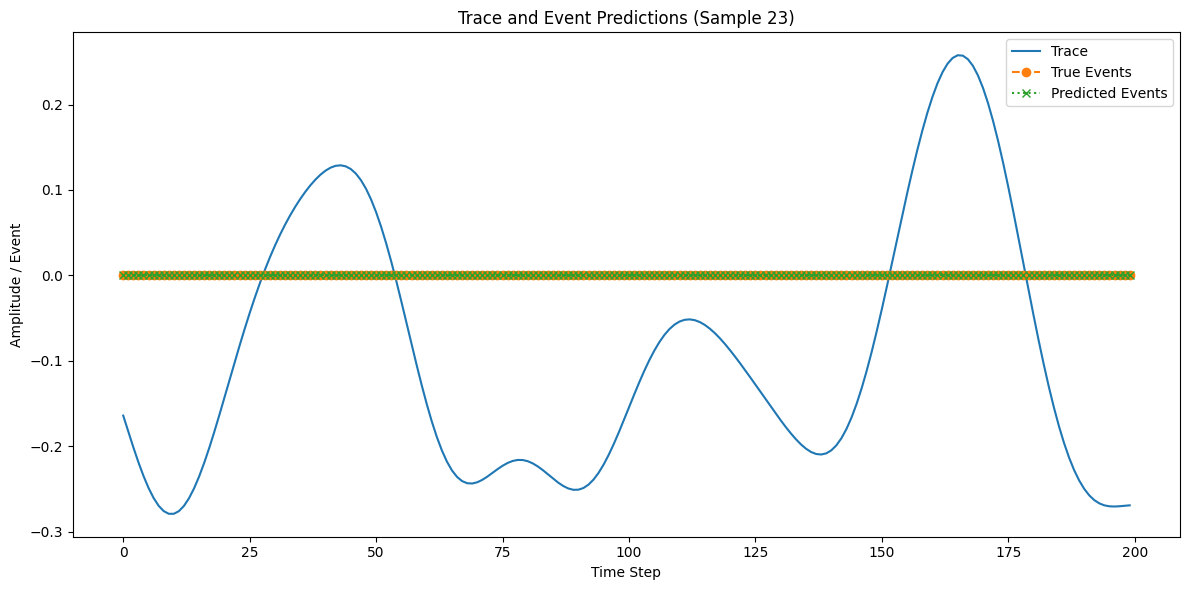

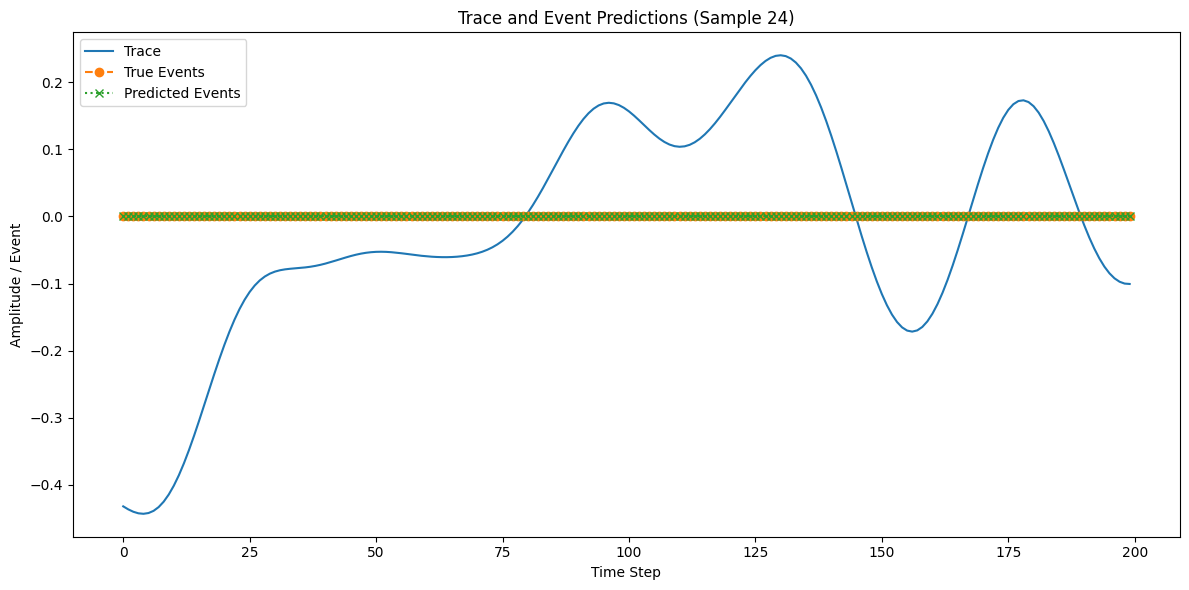

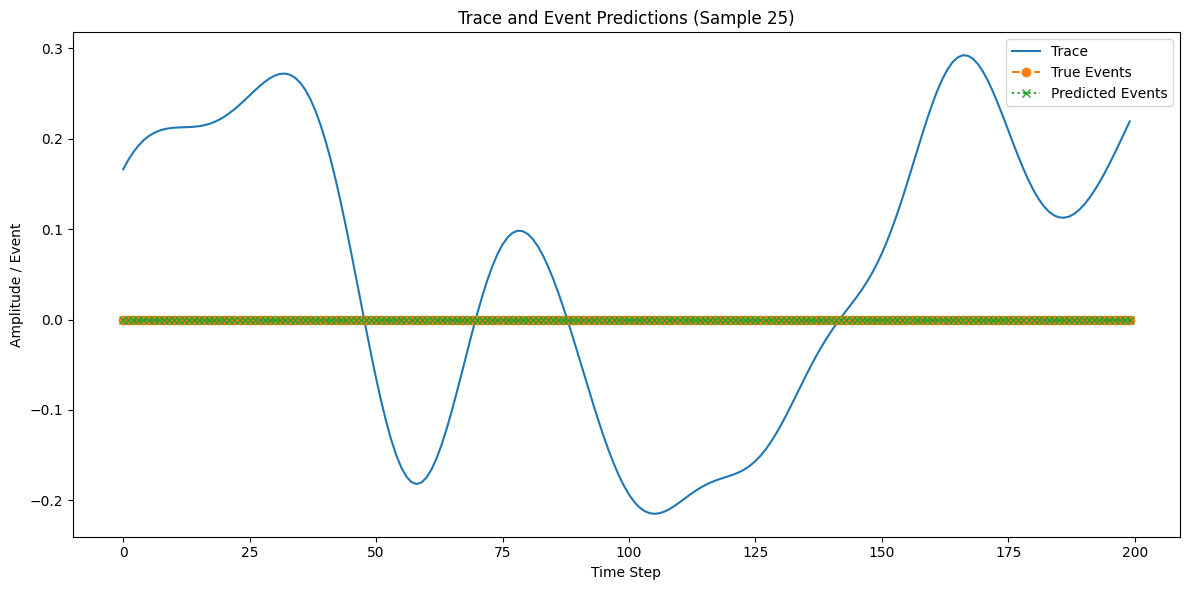

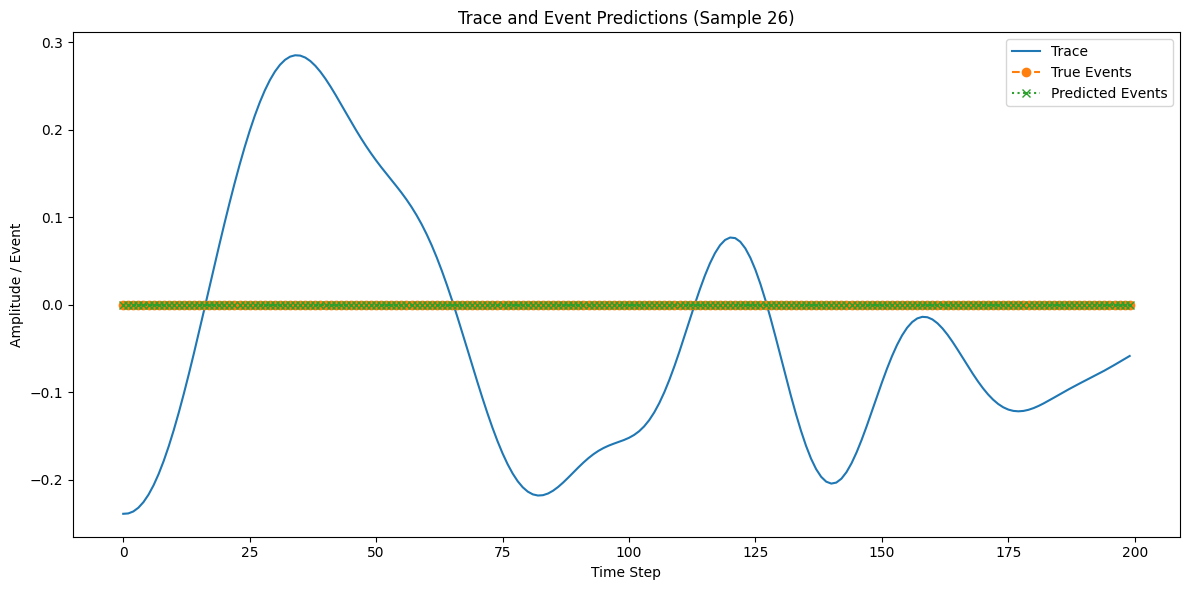

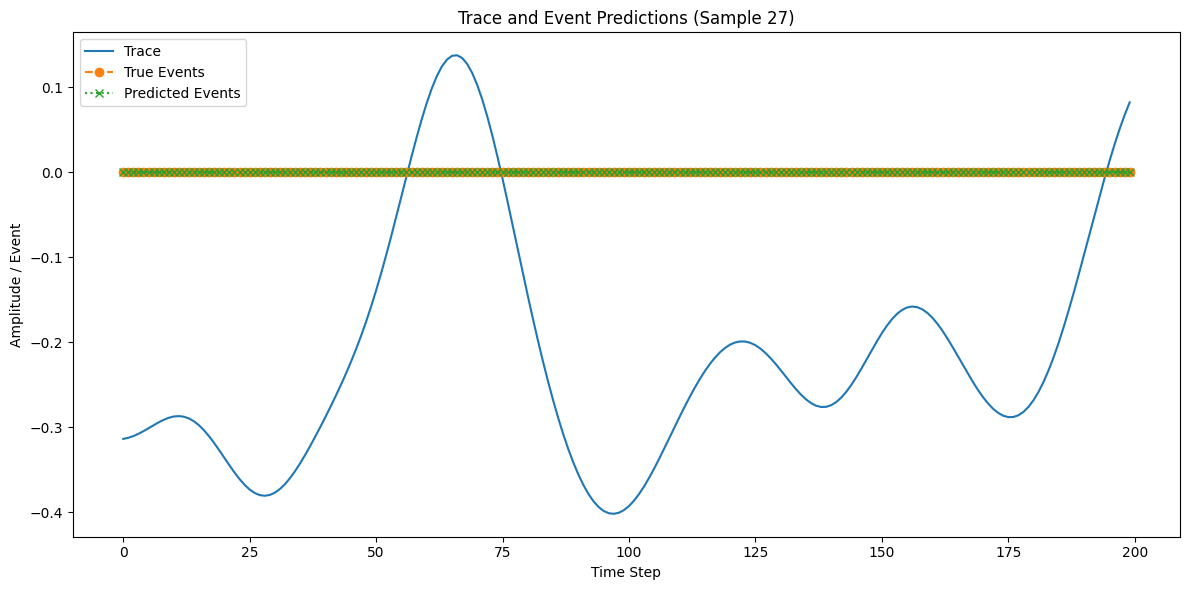

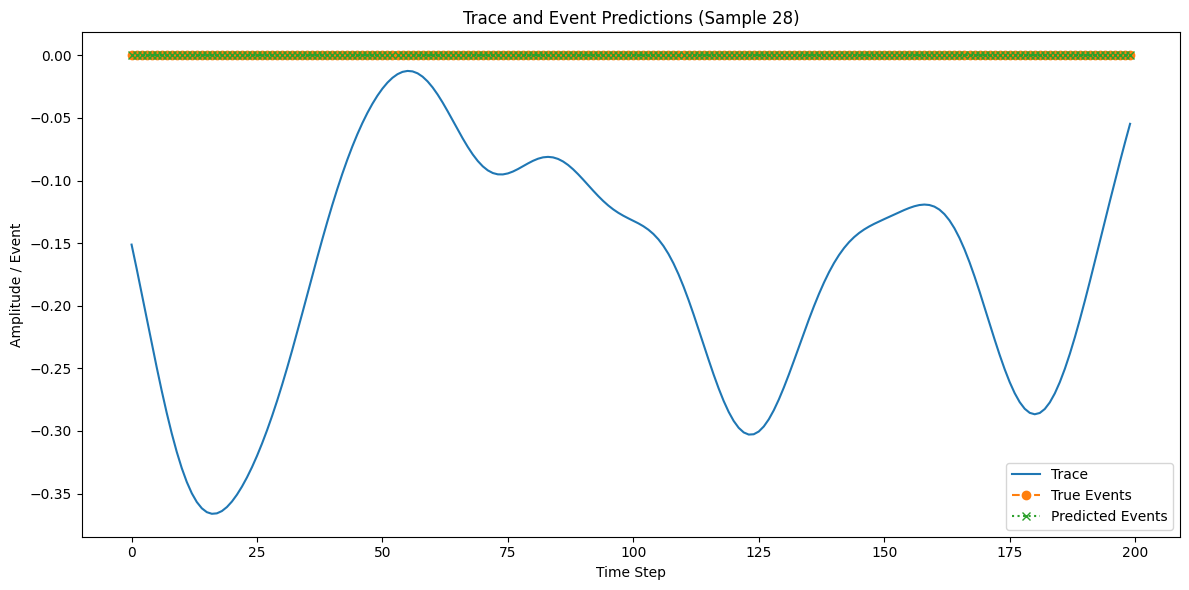

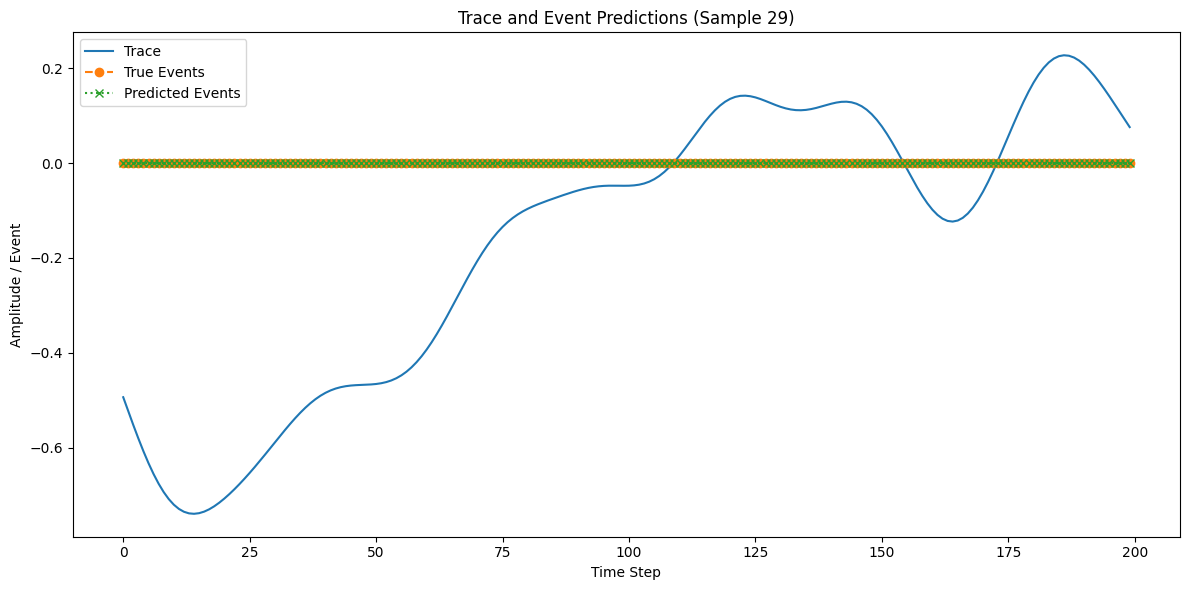

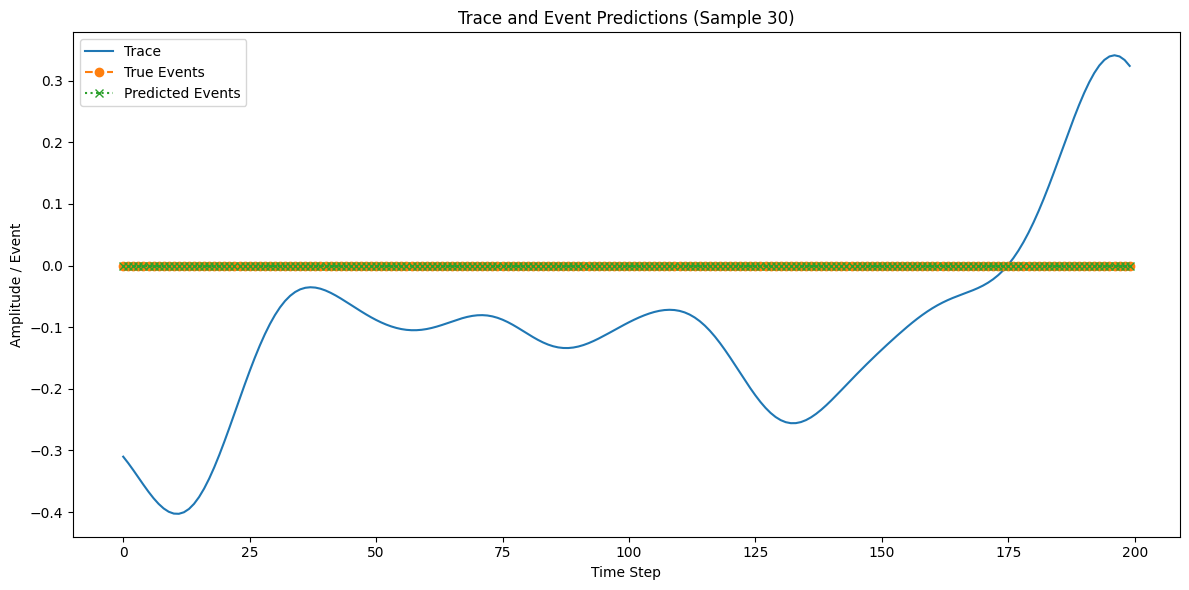

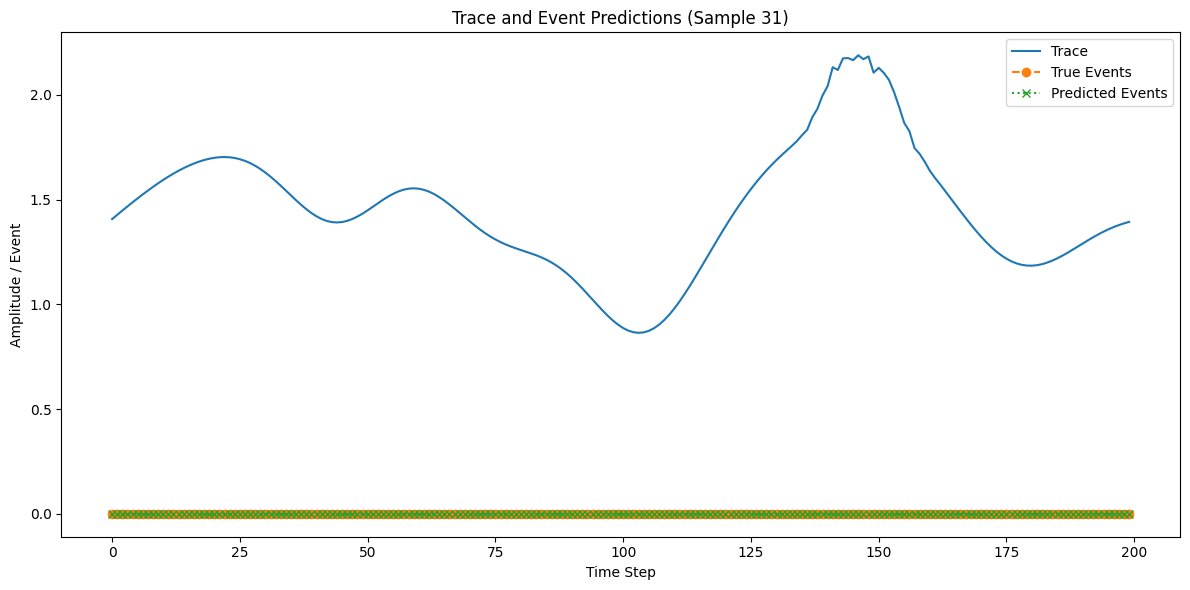

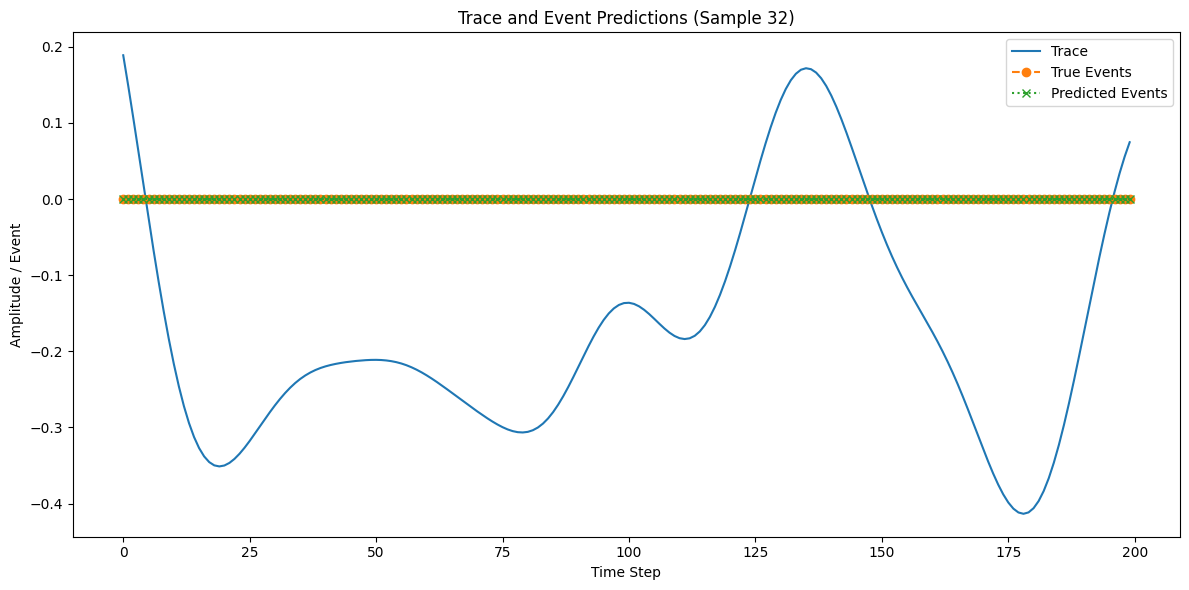

In [12]:
def visualize_predictions(model, data_loader, device, num_samples=1):
    """Visualizes predictions of the model on sample data."""
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            if i >= num_samples:
                break  # Stop after visualizing num_samples

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #outputs = model(inputs.permute(0,2,1))
            threshold = 0.5325 # Example: Lower threshold
            probabilities = torch.softmax(outputs, dim=2) #Softmax to get probabilities
            predicted = (probabilities[:, :, 1] > threshold).long()
            #_, predicted = torch.max(outputs.data, 2)

            inputs_cpu = inputs.cpu().numpy()
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            batch_size = inputs.shape[0]
            seq_len = inputs.shape[1]
            for j in range(batch_size):  # Iterate over batch
                plt.figure(figsize=(12, 6))  # Adjust figure size as needed
                time = np.arange(seq_len)
                plt.plot(time, inputs_cpu[j, :, 0], label="Trace")  # Plot the trace
                plt.plot(time, labels_cpu[j, :], label="True Events", linestyle="--", marker='o')  # Plot true labels
                plt.plot(time, predicted_cpu[j, :], label="Predicted Events", linestyle=":", marker='x')  # Plot predicted labels
                plt.xlabel("Time Step")
                plt.ylabel("Amplitude / Event")
                plt.title(f"Trace and Event Predictions (Sample {i*batch_size + j + 1})")
                plt.legend()
                plt.tight_layout()
                plt.show()


# Example usage: Visualize predictions on the test set
visualize_predictions(model, test_loader, device, num_samples=1)
